In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
%tensorflow_version 1.x

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu

from tensorflow.keras import backend as K
from DeepLab_Config import Config

In [3]:
!gdown https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
!unzip -q ModMonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
To: /content/ModMonuSeg.zip
224MB [00:02, 78.1MB/s]


In [0]:
class Helper():
  def __init__(self):
    self.image_width = 256
    self.image_height = 256
  
  def load_Images(self,parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
    tissue_dir = parent_dir + img_folder
    gt_dir = parent_dir + gt_folder

    self.image_width, self.image_height = im_shape


    ids = next(os.walk(tissue_dir))[2]
    print("No. of images = ", len(ids))

    X = np.zeros((len(ids), self.image_height, self.image_width, 3), dtype=np.float32)
    y = np.zeros((len(ids), self.image_height, self.image_width, 1), dtype=np.float32)

    # tqdm is used to display the progress bar
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
      # Load images
      img = load_img(tissue_dir+id_)
      x_img = img_to_array(img)
      x_img = resize(x_img, (self.image_width, self.image_height, 3), mode = 'constant', preserve_range = True)
      # Load masks
      mask_id_ = id_.split('.')[0]
      mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
      if gt_extension:
        mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
      mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
      mask = resize(mask, (self.image_width, self.image_height, 1), mode = 'constant', preserve_range = True)
      # Save images
      X[n] = x_img/255.0
      y[n] = mask/255.0

    return X, y

  # Some Metrics Functions
  def dice_coefficient(self,y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

  def recall(self,y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(self,y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  ## F1 Score
  def f1_score(self,y_true, y_pred):
    presi = self.precision(y_true, y_pred)
    recall = self.recall(y_true, y_pred)
    return 2*((presi*recall)/(presi+recall+K.epsilon()))
  # Plot the learning curve
  def curve_plot(self,results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();
  
  def plot_sample(self,X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

In [0]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = tf.keras.layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = tf.keras.layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
  """
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

  if not (weights in {'pascal_voc', 'cityscapes', None}):
      raise ValueError('The `weights` argument should be either '
                        '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                        '(pre-trained on PASCAL VOC)')

  if not (backbone in {'xception', 'mobilenetv2'}):
      raise ValueError('The `backbone` argument should be either '
                        '`xception`  or `mobilenetv2` ')

  if input_tensor is None:
      img_input = Input(shape=input_shape)
  else:
      img_input = input_tensor

  if backbone == 'xception':
      if OS == 8:
          entry_block3_stride = 1
          middle_block_rate = 2  # ! Not mentioned in paper, but required
          exit_block_rates = (2, 4)
          atrous_rates = (12, 24, 36)
      else:
          entry_block3_stride = 2
          middle_block_rate = 1
          exit_block_rates = (1, 2)
          atrous_rates = (6, 12, 18)

      x = Conv2D(32, (3, 3), strides=(2, 2),
                  name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
      x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
      x = Activation('relu')(x)

      x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
      x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
      x = Activation('relu')(x)

      x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                          skip_connection_type='conv', stride=2,
                          depth_activation=False)
      x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                  skip_connection_type='conv', stride=2,
                                  depth_activation=False, return_skip=True)

      x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                          skip_connection_type='conv', stride=entry_block3_stride,
                          depth_activation=False)
      for i in range(16):
          x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                              skip_connection_type='sum', stride=1, rate=middle_block_rate,
                              depth_activation=False)

      x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                          skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                          depth_activation=False)
      x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                          skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                          depth_activation=True)

  else:
      OS = 8
      first_block_filters = _make_divisible(32 * alpha, 8)
      x = Conv2D(first_block_filters,
                  kernel_size=3,
                  strides=(2, 2), padding='same',
                  use_bias=False, name='Conv')(img_input)
      x = BatchNormalization(
          epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
      x = Activation(relu6, name='Conv_Relu6')(x)

      x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                              expansion=1, block_id=0, skip_connection=False)

      x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                              expansion=6, block_id=1, skip_connection=False)
      x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                              expansion=6, block_id=2, skip_connection=True)

      x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                              expansion=6, block_id=3, skip_connection=False)
      x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                              expansion=6, block_id=4, skip_connection=True)
      x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                              expansion=6, block_id=5, skip_connection=True)

      # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
      x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                              expansion=6, block_id=6, skip_connection=False)
      x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=7, skip_connection=True)
      x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=8, skip_connection=True)
      x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=9, skip_connection=True)

      x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=10, skip_connection=False)
      x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=11, skip_connection=True)
      x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                              expansion=6, block_id=12, skip_connection=True)

      x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                              expansion=6, block_id=13, skip_connection=False)
      x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                              expansion=6, block_id=14, skip_connection=True)
      x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                              expansion=6, block_id=15, skip_connection=True)

      x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                              expansion=6, block_id=16, skip_connection=False)

  # end of feature extractor

  # branching for Atrous Spatial Pyramid Pooling

  # Image Feature branch
  shape_before = tf.shape(x)
  b4 = GlobalAveragePooling2D()(x)
  # from (b_size, channels)->(b_size, 1, 1, channels)
  b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
  b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
  b4 = Conv2D(256, (1, 1), padding='same',
              use_bias=False, name='image_pooling')(b4)
  b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
  b4 = Activation('relu')(b4)
  # upsample. have to use compat because of the option align_corners
  size_before = tf.keras.backend.int_shape(x)
  b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                  method='bilinear', align_corners=True))(b4)
  # simple 1x1
  b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
  b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
  b0 = Activation('relu', name='aspp0_activation')(b0)

  # there are only 2 branches in mobilenetV2. not sure why
  if backbone == 'xception':
      # rate = 6 (12)
      b1 = SepConv_BN(x, 256, 'aspp1',
                      rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
      # rate = 12 (24)
      b2 = SepConv_BN(x, 256, 'aspp2',
                      rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
      # rate = 18 (36)
      b3 = SepConv_BN(x, 256, 'aspp3',
                      rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

      # concatenate ASPP branches & project
      x = Concatenate()([b4, b0, b1, b2, b3])
  else:
      x = Concatenate()([b4, b0])

  x = Conv2D(256, (1, 1), padding='same',
              use_bias=False, name='concat_projection')(x)
  x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)
  # DeepLab v.3+ decoder

  if backbone == 'xception':
      # Feature projection
      # x4 (x2) block
      size_before2 = tf.keras.backend.int_shape(x)
      x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                      size_before2[1:3] * tf.constant(OS // 4),
                                                      method='bilinear', align_corners=True))(x)

      dec_skip1 = Conv2D(48, (1, 1), padding='same',
                          use_bias=False, name='feature_projection0')(skip1)
      dec_skip1 = BatchNormalization(
          name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
      dec_skip1 = Activation('relu')(dec_skip1)
      x = Concatenate()([x, dec_skip1])
      x = SepConv_BN(x, 256, 'decoder_conv0',
                      depth_activation=True, epsilon=1e-5)
      x = SepConv_BN(x, 256, 'decoder_conv1',
                      depth_activation=True, epsilon=1e-5)

  # you can use it with arbitary number of classes
  if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
      last_layer_name = 'logits_semantic'
  else:
      last_layer_name = 'custom_logits_semantic'

  x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
  size_before3 = tf.keras.backend.int_shape(img_input)
  x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                  size_before3[1:3],
                                                  method='bilinear', align_corners=True))(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
      inputs = get_source_inputs(input_tensor)
  else:
      inputs = img_input

  if activation in {'softmax', 'sigmoid'}:
      x = tf.keras.layers.Activation(activation)(x)

  model = Model(inputs, x, name='deeplabv3plus')

  # load weights

  if weights == 'pascal_voc':
      if backbone == 'xception':
          weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                  WEIGHTS_PATH_X,
                                  cache_subdir='models')
      else:
          weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                  WEIGHTS_PATH_MOBILE,
                                  cache_subdir='models')
      model.load_weights(weights_path, by_name=True)
  elif weights == 'cityscapes':
      if backbone == 'xception':
          weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                  WEIGHTS_PATH_X_CS,
                                  cache_subdir='models')
      else:
          weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                  WEIGHTS_PATH_MOBILE_CS,
                                  cache_subdir='models')
      model.load_weights(weights_path, by_name=True)
  return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [6]:
config = Config()
helper = Helper()
X, y = helper.load_Images(config.train_parent_dir, (config.im_width, config.im_height),config.img_folder, config.gt_folder, config.train_gt_extension)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
model = Deeplabv3(weights=None, input_tensor=None, input_shape=(256, 256, 3), classes=1, backbone='xception',
              OS=16, alpha=1., activation='sigmoid')
model.compile(optimizer=config.optimizer, loss="binary_crossentropy", metrics=["accuracy", helper.dice_coefficient, helper.f1_score])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 128, 128, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           entry_flow_conv1_1_BN[0][0]      
______________________________________________________________________________________

In [9]:
history=model.fit(X_train, y_train, batch_size=config.batch_size, epochs=config.epochs, callbacks=config.callbacks,
                    validation_data=(X_valid, y_valid))

Train on 972 samples, validate on 108 samples
Epoch 1/60
966/972 [============================>.] - ETA: 0s - loss: 0.3426 - acc: 0.8452 - dice_coefficient: 0.6122 - f1_score: 0.6902
Epoch 00001: val_loss improved from inf to 0.59763, saving model to deeplab-model.h5
972/972 [==============================] - 173s 178ms/sample - loss: 0.3427 - acc: 0.8452 - dice_coefficient: 0.6125 - f1_score: 0.6904 - val_loss: 0.5976 - val_acc: 0.7267 - val_dice_coefficient: 0.2359 - val_f1_score: 0.0000e+00
Epoch 2/60
966/972 [============================>.] - ETA: 0s - loss: 0.2764 - acc: 0.8790 - dice_coefficient: 0.6876 - f1_score: 0.7736
Epoch 00002: val_loss did not improve from 0.59763
972/972 [==============================] - 46s 47ms/sample - loss: 0.2763 - acc: 0.8791 - dice_coefficient: 0.6877 - f1_score: 0.7737 - val_loss: 0.7047 - val_acc: 0.7267 - val_dice_coefficient: 0.1461 - val_f1_score: 0.0000e+00
Epoch 3/60
966/972 [============================>.] - ETA: 0s - loss: 0.2583 - acc: 

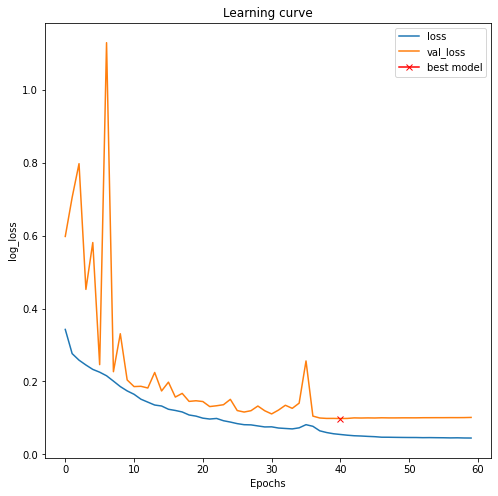

In [10]:
helper.curve_plot(history)

In [11]:
X_test, y_test = helper.load_Images(config.test_parent_dir, (config.im_width, config.im_height),
                  config.img_folder, config.gt_folder, config.test_gt_extension)
model.evaluate(X_test, y_test, verbose=1)

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



504/504 [==============================] - 5s 11ms/sample - loss: 0.4256 - acc: 0.9080 - dice_coefficient: 0.7735 - f1_score: 0.7813


[0.42560952807229663, 0.90799546, 0.7734833, 0.7813281]

In [12]:
preds = model.predict(X_test, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

504/504 [==============================] - 7s 13ms/sample


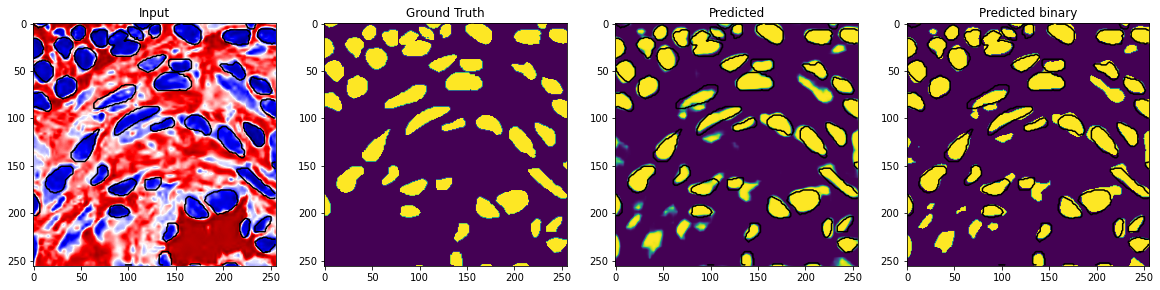

In [13]:
# Check if training data looks all right
helper.plot_sample(X_test, y_test, preds, preds_t)